In [1]:
#@markdown **Main variables**
artist = 'yvnglvcas' #@param {type:'string'}
song_name = 'LaBebe' #@param {type:'string'}
version = 'V2' #@param {type:'string'}

#@markdown **Parameters for keyframe generation for translation_z**
youtube_link = 'https://www.youtube.com/watch?v=0_Q42Fdwl6U' # @param {type:'string'}
start_timestamp = '00:00:00.00' # @param {type:'string'}
end_timestamp = '00:04:52.00' # @param {type:'string'}
from datetime import datetime
fps = 15 #@param {type:'number'}
function='1+12*(x**2)' #@param{type:'string'}
stem_segment = 'drums' #@param ["drums", "bass", "vocals","other"]

width = 640   #360
height = 360  #640

prompts = [
]
# style="art, painting, artstation, unreal engine 5, 4 k detailed, octane render, intricate, hyperrealistic. very detailed, 8 k resolution, hd quality 1 6 k resolution, trending on artstation, trending on deviantart, artstation hq, deviantart, pinterest, photoreal"#"Unreal Engine 5" # 'photo realistic','digital art', 

style = "Unreal Engine 5!!!"
prefix="long shot zoomed out"
animation_prompts = {
0:    f"woman dancing in the rain, her clothes soaked, as she climbs into a Mercedes-Benz. The stars twinkle above, creating a dreamy, ethereal atmosphere, trending on artstation, highly detailed, 4k wallpaper, 4k, award winning, unreal engine, octane render, sharp focus, volumetric lighting, cinematic lighting, atmospheric, {style}", 
400:  f"{prefix},nightclub, with bright, flashing lights and a packed dance floor. A couple dancing together, highly detailed, 8k, masterpiece, super resolution. photorealistic, cinematic lighting. HDR. 4k., {style}",
800:  f"{prefix},two people wrapped in each other's arms, dimly lit, high contrast, dark light, cinematic, atmospheric, ultra detailed, sharp, 8 k, trending on artstation, cgsociety, hdr, movie still frame, dynamic lighting, intricate detail, summer vibrancy, cinematic, centered, sharp focus, {style}",
1200: f"{prefix},woman in a crop top and shorts, smoking a cigarette and drinking from a red cup standing in front of a graffiti-covered wall, with a mischievous expression on her face, high res, 8k, 4k, high detail, high detail, professional photography, ultra-detail, professional lighting, trending on artstation, volumetric lighting, hdr, polished, ray traced, octane render, {style}",
1600: f"{prefix},luxurious sports car driving down a highway at night, headlights illuminate the road ahead in the background, high details, cinematic, cgsociety 8k resolution, beautiful detailed, photorealistic, digital painting, dark atmosphere, artstation, concept art, smooth, sharp focus, artstation trending, octane render, {style}",
2000: f"{prefix},nightclub with people dancing and drinking. In the center of the room, a beautiful woman dancing her hair flowing, twirling, artistic, highly detailed, intricate, beautiful eyes, trending on art station', {style}", 
2400: f"{prefix},two people lying in bed as they smoke a joint, room is filled with smoke, hazy, dream-like atmosphere, surreal atmosphere, 4k, 8k, artstationhq, artstationhd, artstationhq, unreal engine, 4k, 8k, photorealistic imagery, {style}",
2800: f"{prefix},a woman dancing on a rooftop, with the city skyline in the background, bright moonlight, digital art, trending on artstation, 4k, hd wallpaper, award winning, intricate, ultra detailed, sharp focus, 8k, unreal engine 5, 4k uhd, {style}",
3200: f"{prefix},a woman with long hair sitting in the passenger seat of a car, glass of champagne, while the driver focuses on the road ahead. the sun in the window, golden ratio, wide shot, atmospheric lighting, award winning. masterpiece, exquisite detail, post processing, deviantart, 8 k, trending on artstation', {style}",
3600: f"{prefix},woman dancing alone in a room, with the music blasting from a speaker in the back, wearing a long coat, very beautiful, intricate, highly detailed, digital painting, artstation, smooth, sharp focus, illustration, 8 k, unreal engine 5, global illumination, radiant light, detailed and intricate, {style}",
}

In [2]:
#@markdown **NVIDIA GPU**
import time
start = time.time()
import subprocess, os, sys
sub_p_res = subprocess.run(['nvidia-smi', '--query-gpu=name,memory.total,memory.free', '--format=csv,noheader'], stdout=subprocess.PIPE).stdout.decode('utf-8')
print(f"{sub_p_res[:-1]}")

import subprocess, time, gc, os, sys
if not os.path.exists('deforum-stable-diffusion'):
    running = subprocess.run(['git','clone','https://github.com/deforum-art/deforum-stable-diffusion'],stdout=subprocess.PIPE).stdout.decode('utf-8')
# all_process = [
#             ['pip', 'install', '-q','omegaconf', 'einops==0.4.1', 'pytorch-lightning==1.7.7', 'torchmetrics', 'transformers', 'safetensors', 'kornia','opencv-python'],
#             ['git', 'clone', 'https://github.com/deforum-art/deforum-stable-diffusion'],
#             ['pip', 'install','-q', 'accelerate', 'ftfy', 'jsonmerge', 'matplotlib', 'resize-right', 'timm', 'torchdiffeq','scikit-learn','torchsde','open-clip-torch','numpngw'],
#         ]
# for process in all_process:
#     running = subprocess.run(process,stdout=subprocess.PIPE).stdout.decode('utf-8')
with open('deforum-stable-diffusion/src/k_diffusion/__init__.py', 'w') as f:
    f.write('')
sys.path.extend([
    'deforum-stable-diffusion/',
    'deforum-stable-diffusion/src',
])
if not os.path.exists('configs'):
    subprocess.run(['cp', '-avr', 'deforum-stable-diffusion/configs', 'configs'])
# all_process = [['pip', 'install', 'triton==2.0.0.dev20221202']]
# for process in all_process:
#     running = subprocess.run(process,stdout=subprocess.PIPE).stdout.decode('utf-8')
    
import torch
import random
import clip
from IPython import display
from types import SimpleNamespace
from helpers.save_images import get_output_folder
from helpers.settings import load_args
from helpers.render import render_animation, render_input_video, render_image_batch, render_interpolation
from helpers.model_load import make_linear_decode, load_model, get_model_output_paths
from helpers.aesthetics import load_aesthetics_model

#@markdown **Path Setup**

def Root():
    models_path = "resources/models" #@param {type:"string"}
    configs_path = "resources/configs" #@param {type:"string"}
    output_path = "resources/outputs" #@param {type:"string"}
    mount_google_drive = False #@param {type:"boolean"}
    models_path_gdrive = "/content/drive/MyDrive/AI/models" #@param {type:"string"}
    output_path_gdrive = "/content/drive/MyDrive/AI/StableDiffusion" #@param {type:"string"}

    #@markdown **Model Setup**
    map_location = "cuda" #@param ["cpu", "cuda"]
    model_config = "v1-inference.yaml" #@param ["custom","v2-inference.yaml","v2-inference-v.yaml","v1-inference.yaml"]
    model_checkpoint =  "sd-v1-4.ckpt" #@param ["custom","v2-1_768-ema-pruned.ckpt","v2-1_512-ema-pruned.ckpt","768-v-ema.ckpt","512-base-ema.ckpt","Protogen_V2.2.ckpt","v1-5-pruned.ckpt","v1-5-pruned-emaonly.ckpt","sd-v1-4-full-ema.ckpt","sd-v1-4.ckpt","sd-v1-3-full-ema.ckpt","sd-v1-3.ckpt","sd-v1-2-full-ema.ckpt","sd-v1-2.ckpt","sd-v1-1-full-ema.ckpt","sd-v1-1.ckpt", "robo-diffusion-v1.ckpt","wd-v1-3-float16.ckpt"]
    custom_config_path = "deforum-stable-diffusion/configs" #@param {type:"string"}
    custom_checkpoint_path = "" #@param {type:"string"}
    return locals()

root = Root()
root = SimpleNamespace(**root)

root.models_path, root.output_path = get_model_output_paths(root)
root.model, root.device = load_model(root, load_on_run_all=True, check_sha256=False, map_location=root.map_location)
print("Done loading :)")

#@markdown **Set up source-separation**
# ! pip install --quiet librosa numpy pandas demucs soundfile pyfluidsynth mido

import librosa
import numpy as np
import os
import pandas as pd
import io
from pathlib import Path
from shutil import rmtree
import subprocess as sp
import soundfile as sf

from dataclasses import dataclass
from mido import MidiFile

@dataclass
class DeMixedAudio4():
    sample_rate: int
    bass : np.ndarray
    drums : np.ndarray
    other : np.ndarray
    vocals : np.ndarray

@dataclass
class DeMixedAudio6():
    sample_rate: int
    bass : np.ndarray
    drums : np.ndarray
    other : np.ndarray
    vocals : np.ndarray
    piano : np.ndarray
    guitar : np.ndarray
import mido
@dataclass
class ProcessedSong4():
    stems:DeMixedAudio4
    vocal_based_midi: mido.midifiles.midifiles.MidiFile
    melody_based_midi:mido.midifiles.midifiles.MidiFile
    full_song_based_midi:mido.midifiles.midifiles.MidiFile
    
@dataclass
class ProcessedSong6():
    stems:DeMixedAudio6
    vocal_based_midi: mido.midifiles.midifiles.MidiFile
    melody_based_midi:mido.midifiles.midifiles.MidiFile
    full_song_based_midi:mido.midifiles.midifiles.MidiFile

def get_stems(path_to_file,model='htdemucs',output_path='resources/tmp',delete_temp_files=True, return_demixed_audio=True):
    file_name = os.path.basename(path_to_file)
    sp.run(["python3", "-m", "demucs.separate", "-o", output_path, "-n", model, path_to_file])
    # print("Demucs done, loading files")
    if not return_demixed_audio:
        return
    stems={}
    if model in ['htdemucs','htdemucs_ft']:
        for stem in ['bass','drums','other','vocals']:
            x,sr = librosa.load(os.path.join(output_path, model,file_name[:file_name.find('.')],f"{stem}.wav"), sr=None)
            stems[stem] = x
        if delete_temp_files:
            print("Deleting temp files")
            rmtree(f"{output_path}/{model}/{file_name[:file_name.find('.')]}")
        return DeMixedAudio4(sr, bass=stems['bass'], drums=stems['drums'], other=stems['other'], vocals=stems['vocals'])#stems
    elif model == 'htdemucs_6s':
        for stem in ['bass','drums','other','vocals','piano', 'guitar']:
            x,sr = librosa.load(os.path.join(output_path, model,file_name[:file_name.find('.')],f"{stem}.wav"), sr=None)
            stems[stem] = x
        if delete_temp_files:
            print("Deleting temp files")
            rmtree(f"{output_path}/{model}/{file_name[:file_name.find('.')]}")
        return DeMixedAudio6(sr, bass=stems['bass'], drums=stems['drums'], other=stems['other'], vocals=stems['vocals'], piano=stems['piano'], guitar=stems['guitar'])#stems 


Tesla T4, 15360 MiB, 14969 MiB
models_path: /home/ec2-user/SageMaker/video-generation-Deforum/resources/models
output_path: /home/ec2-user/SageMaker/video-generation-Deforum/resources/outputs
config_path: /home/ec2-user/SageMaker/video-generation-Deforum/configs/v1-inference.yaml
ckpt_path: /home/ec2-user/SageMaker/video-generation-Deforum/resources/models/sd-v1-4.ckpt
..loading model
Done loading :)


In [3]:
import subprocess as sp
# !conda install -c conda-forge ffmpeg
# ! pip install ffmpeg
!sudo yum install -y -q epel-release
!sudo yum localinstall --nogpgcheck -y -q https://download1.rpmfusion.org/free/el/rpmfusion-free-release-7.noarch.rpm
!sudo yum install -y -q ffmpeg ffmpeg-devel
subprocess.run(['mv','/home/ec2-user/anaconda3/envs/pytorch_p39/lib/libopenh264.so','/home/ec2-user/anaconda3/envs/pytorch_p39/lib/libopenh264.so.5'])


https://download.docker.com/linux/centos/2/x86_64/stable/repodata/repomd.xml: [Errno 14] HTTPS Error 404 - Not Found
Trying other mirror.
Package epel-release-7-14.noarch already installed and latest version
https://download.docker.com/linux/centos/2/x86_64/stable/repodata/repomd.xml: [Errno 14] HTTPS Error 404 - Not Found
Trying other mirror.
Error: Package: libmfx-1.21-2.el7.x86_64 (epel)
           Requires: libva-drm.so.1()(64bit)
Error: Package: ffmpeg-libs-3.4.12-1.el7.x86_64 (rpmfusion-free-updates)
           Requires: libva-drm.so.1()(64bit)
Error: Package: libmfx-1.21-2.el7.x86_64 (epel)
           Requires: libva-x11.so.1()(64bit)
Error: Package: ffmpeg-libs-3.4.12-1.el7.x86_64 (rpmfusion-free-updates)
           Requires: libva-x11.so.1()(64bit)
Error: Package: ffmpeg-libs-3.4.12-1.el7.x86_64 (rpmfusion-free-updates)
           Requires: libva.so.1()(64bit)
Error: Package: ffmpeg-libs-3.4.12-1.el7.x86_64 (rpmfusion-free-updates)
           Requires: libva.so.1(VA_API_0.33.0

mv: cannot stat ‘/home/ec2-user/anaconda3/envs/pytorch_p39/lib/libopenh264.so’

CompletedProcess(args=['mv', '/home/ec2-user/anaconda3/envs/pytorch_p39/lib/libopenh264.so', '/home/ec2-user/anaconda3/envs/pytorch_p39/lib/libopenh264.so.5'], returncode=1)

: No such file or directory


In [4]:
!ffmpeg -version
sp.run(['yt-dlp','-ciwx', '--extract-audio',  '--audio-format', 'wav','--no-part', youtube_link,'-o', 'audio_tmp.wav'])#, '--download-sections', f"*{start_timestamp}-{end_timestamp}",])
sp.run(['ffmpeg','-i','audio_tmp.wav','-ss',start_timestamp,'-to', end_timestamp, 'audio.wav','-y'])
sp.run(['rm','audio_tmp.wav'])
get_stems('audio.wav',model='htdemucs_ft',output_path='source_separated',delete_temp_files=False, return_demixed_audio=False)

ffmpeg version 5.1.2 Copyright (c) 2000-2022 the FFmpeg developers
built with gcc 11.3.0 (conda-forge gcc 11.3.0-19)
configuration: --prefix=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-cc --cxx=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-c++ --nm=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-nm --ar=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-ar --disable-doc --disable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libfontconfig --enable-libopenh264 --enable-gnutls 

ffmpeg version 5.1.2 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 11.3.0 (conda-forge gcc 11.3.0-19)
  configuration: --prefix=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-cc --cxx=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-c++ --nm=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-nm --ar=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-ar --disable-doc --disable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libfontconfig --enable-libopenh264 --enable-gnu

Selected model is a bag of 4 models. You will see that many progress bars per track.
Separated tracks will be stored in /home/ec2-user/SageMaker/video-generation-Deforum/source_separated/htdemucs_ft
Separating track audio.wav


100%|████████████████████████████████████████████████████████████████████████| 292.5/292.5 [00:14<00:00, 20.82seconds/s]
100%|████████████████████████████████████████████████████████████████████████| 292.5/292.5 [00:10<00:00, 26.76seconds/s]
100%|████████████████████████████████████████████████████████████████████████| 292.5/292.5 [00:10<00:00, 26.69seconds/s]
100%|████████████████████████████████████████████████████████████████████████| 292.5/292.5 [00:10<00:00, 26.62seconds/s]


In [5]:
#@markdown **Generate translation_z**
import numpy as np
import librosa
import scipy.io.wavfile as wavfile
import math
import soundfile as sf
max_frames = int(fps*(datetime.strptime(end_timestamp, '%H:%M:%S.%f') - datetime.strptime(start_timestamp, '%H:%M:%S.%f')).total_seconds())
# fps = 15 #@param {type:"number"}
def filter_data(audio_file_path, framerate, fn='1+x**4', format='disco'):
    # Load audio file
    # sample_rate, data = wavfile.read(audio_file_path)
    # raw_data,sample_rate = librosa.load(audio_file_path, sr=None, mono=True)
    raw_data, sample_rate = sf.read(audio_file_path)
    if raw_data.shape[1] != 1:
        raw_data = raw_data.mean(axis=1)
    # # Average between channels. Take abs so we don't have phase issues (and we eventually want absolute value anyway, for volume).
    # def add_abs_array_elements(a, b):
    #     return np.abs(a) + np.abs(b)

    # channels = np.array([data[:, i] for i in range(data.shape[1])])
    # raw_data = np.apply_along_axis(add_abs_array_elements, 0, channels).mean(axis=0)
    
    samples = int(len(raw_data) / (sample_rate / framerate))+1
    block_size = int(len(raw_data) / samples)
    raw_data = raw_data/max(abs(raw_data))
    filtered_data = []
    for i in range(samples):
        chunk = abs(raw_data[i * block_size:(i + 1) * block_size - 1])
        # chunk=chunk/max(chunk)
        filtered_data.append(np.mean(chunk))
    
    # Normalize
    max_val = max(filtered_data)
    filtered_data = [x / max_val for x in filtered_data]

    # Evaluate expression for each point in filtered data
    filtered_data = [round(eval(fn.replace("x", str(x)).replace("y", str(ind))),2) for ind, x in enumerate(filtered_data)]

    # Format output based on selected format
    if format == "disco":
        output = filtered_data
    elif format == "csv":
        output = "\n".join([str(x) for x in filtered_data])

    l=""
    for i in range(len(output)):
        l+=f"{i}:({output[i]}), "
    return l[:-2]
import numpy as np
def get_translation_x(animation_prompts,max_frames):
    prompt_frames=list(animation_prompts.keys())
    prompt_frames.append(max_frames)
    translation_x=[]
    for i in range(len(prompt_frames)):
        if prompt_frames[i] == 0:
            initial_x = 0.3
            continue
        translation_x.append(np.linspace(initial_x, random.randint(30,102)/100, prompt_frames[i]-prompt_frames[i-1]))
    l = np.concatenate(translation_x)
    s=""
    for i in range(len(l)):
      s+=f"{i}:({round(l[i],2)}), "
    s+=f"{i+1}:({round(l[i],2)}), "
    return s[:-2]

def get_translation_y(animation_prompts,max_frames):
    prompt_frames=list(animation_prompts.keys())
    prompt_frames.append(max_frames)
    translation_y=[]
    for i in range(len(prompt_frames)):
        if prompt_frames[i] == 0:
            initial_y = 0.3
            continue
        translation_y.append(np.linspace(initial_y, random.randint(30,102)/100, prompt_frames[i]-prompt_frames[i-1]))
    l = np.concatenate(translation_y)
    s=""
    for i in range(len(l)):
        s+=f"{i}:({round(l[i],2)}), "
    s+=f"{i+1}:({round(l[i],2)}), "
    return s[:-2]

def DeforumAnimArgs():

    #@markdown ####**Animation:**
    animation_mode = '3D' #@param ['None', '2D', '3D', 'Video Input', 'Interpolation'] {type:'string'}
    max_frames = int(fps*(datetime.strptime(end_timestamp, '%H:%M:%S.%f') - datetime.strptime(start_timestamp, '%H:%M:%S.%f')).total_seconds())
    border = 'replicate' #@param ['wrap', 'replicate'] {type:'string'}

    #@markdown ####**Motion Parameters:**
    angle = "0:(0)"#@param {type:"string"}
    zoom = "0:(1.04)"#@param {type:"string"}
    translation_x = get_translation_x(animation_prompts,max_frames)
    translation_y = get_translation_y(animation_prompts,max_frames)
    # translation_x = "0:(0.36),1:(0.37),2:(0.37),3:(0.38),4:(0.38),5:(0.39),6:(0.39),7:(0.4),8:(0.4),9:(0.41),10:(0.41),11:(0.42),12:(0.42),13:(0.43),14:(0.43),15:(0.44),16:(0.44),17:(0.45),18:(0.45),19:(0.46),20:(0.46),21:(0.47),22:(0.47),23:(0.48),24:(0.48),25:(0.49),26:(0.49),27:(0.5),28:(0.5),29:(0.51),30:(0.52),31:(0.52),32:(0.53),33:(0.53),34:(0.54),35:(0.54),36:(0.55),37:(0.55),38:(0.56),39:(0.56),40:(0.57),41:(0.57),42:(0.58),43:(0.58),44:(0.59),45:(0.59),46:(0.6),47:(0.6),48:(0.61),49:(0.61),50:(0.62),51:(0.62),52:(0.63),53:(0.63),54:(0.64),55:(0.65),56:(0.65),57:(0.66),58:(0.66),59:(0.67),60:(0.67),61:(0.68),62:(0.68),63:(0.69),64:(0.69),65:(0.7),66:(0.7),67:(0.71),68:(0.71),69:(0.71),70:(0.72),71:(0.72),72:(0.73),73:(0.73),74:(0.74),75:(0.74),76:(0.75),77:(0.75),78:(0.76),79:(0.76),80:(0.77),81:(0.77),82:(0.78),83:(0.78),84:(0.79),85:(0.79),86:(0.79),87:(0.8),88:(0.8),89:(0.81),90:(0.81),91:(0.82),92:(0.82),93:(0.82),94:(0.83),95:(0.83),96:(0.84),97:(0.84),98:(0.85),99:(0.85),100:(0.85),101:(0.86),102:(0.86),103:(0.87),104:(0.87),105:(0.87),106:(0.88),107:(0.88),108:(0.88),109:(0.89),110:(0.89),111:(0.89),112:(0.9),113:(0.9),114:(0.91),115:(0.91),116:(0.91),117:(0.92),118:(0.92),119:(0.92),120:(0.92),121:(0.93),122:(0.93),123:(0.93),124:(0.94),125:(0.94),126:(0.94),127:(0.95),128:(0.95),129:(0.95),130:(0.95),131:(0.96),132:(0.96),133:(0.96),134:(0.96),135:(0.97),136:(0.97),137:(0.97),138:(0.97),139:(0.98),140:(0.98),141:(0.98),142:(0.98),143:(0.98),144:(0.99),145:(0.99),146:(0.99),147:(0.99),148:(0.99),149:(1),150:(1),151:(1),152:(1),153:(1),154:(1),155:(1.01),156:(1.01),157:(1.01),158:(1.01),159:(1.01),160:(1.01),161:(1.01),162:(1.01),163:(1.02),164:(1.02),165:(1.02),166:(1.02),167:(1.02),168:(1.02),169:(1.02),170:(1.02),171:(1.02),172:(1.02),173:(1.02),174:(1.02),175:(1.02),176:(1.02),177:(1.02),178:(1.02),179:(1.02),180:(1.02),181:(1.02),182:(1.02),183:(1.02),184:(1.02),185:(1.02),186:(1.02),187:(1.02),188:(1.02),189:(1.02),190:(1.02),191:(1.02),192:(1.02),193:(1.02),194:(1.02),195:(1.02),196:(1.02),197:(1.02),198:(1.01),199:(1.01),200:(1.01),201:(1.01),202:(1.01),203:(1.01),204:(1.01),205:(1.01),206:(1),207:(1),208:(1),209:(1),210:(1),211:(1),212:(0.99),213:(0.99),214:(0.99),215:(0.99),216:(0.99),217:(0.98),218:(0.98),219:(0.98),220:(0.98),221:(0.98),222:(0.97),223:(0.97),224:(0.97),225:(0.97),226:(0.96),227:(0.96),228:(0.96),229:(0.96),230:(0.95),231:(0.95),232:(0.95),233:(0.94),234:(0.94),235:(0.94),236:(0.94),237:(0.93),238:(0.93),239:(0.93),240:(0.92),241:(0.92),242:(0.92),243:(0.91),244:(0.91),245:(0.91),246:(0.9),247:(0.9),248:(0.9),249:(0.89),250:(0.89),251:(0.88),252:(0.88),253:(0.88),254:(0.87),255:(0.87),256:(0.86),257:(0.86),258:(0.86),259:(0.85),260:(0.85),261:(0.84),262:(0.84),263:(0.84),264:(0.83),265:(0.83),266:(0.82),267:(0.82),268:(0.81),269:(0.81),270:(0.8),271:(0.8),272:(0.8),273:(0.79),274:(0.79),275:(0.78),276:(0.78),277:(0.77),278:(0.77),279:(0.76),280:(0.76),281:(0.75),282:(0.75),283:(0.74),284:(0.74),285:(0.73),286:(0.73),287:(0.72),288:(0.72),289:(0.71),290:(0.71),291:(0.7),292:(0.7),293:(0.69),294:(0.68),295:(0.68),296:(0.67),297:(0.67),298:(0.66),299:(0.66),300:(0.65),301:(0.65),302:(0.64),303:(0.64),304:(0.63),305:(0.62),306:(0.62),307:(0.61),308:(0.61),309:(0.6),310:(0.6),311:(0.59),312:(0.58),313:(0.58),314:(0.57),315:(0.57),316:(0.56),317:(0.55),318:(0.55),319:(0.54),320:(0.54),321:(0.53),322:(0.52),323:(0.52),324:(0.51),325:(0.51),326:(0.5),327:(0.49),328:(0.49),329:(0.48),330:(0.48),331:(0.47),332:(0.46),333:(0.46),334:(0.45),335:(0.45),336:(0.44),337:(0.43),338:(0.43),339:(0.42),340:(0.41),341:(0.41),342:(0.4),343:(0.4),344:(0.39),345:(0.38),346:(0.38),347:(0.37),348:(0.36),349:(0.36),350:(0.35),351:(0.34),352:(0.34),353:(0.33),354:(0.33),355:(0.32),356:(0.31),357:(0.31),358:(0.3),359:(0.29),360:(0.29),361:(0.28),362:(0.28),363:(0.27),364:(0.26),365:(0.26),"#@param {type:"string"}
    # translation_y = "0:(0.02),1:(0.02),2:(0.01),3:(0.01),4:(0.01),5:(0.01),6:(0.01),7:(0.01),8:(0.01),9:(0.01),10:(0.01),11:(0.01),12:(0.01),13:(0.01),14:(0.01),15:(0.01),16:(0.01),17:(0.01),18:(0.01),19:(0.01),20:(0.01),21:(0.01),22:(0.01),23:(0.01),24:(0.01),25:(0.01),26:(0.01),27:(0.01),28:(0.01),29:(0.01),30:(0.01),31:(0.01),32:(0.01),33:(0.01),34:(0.01),35:(0),36:(0),37:(0),38:(0),39:(0),40:(0),41:(0),42:(0),43:(0),44:(0),45:(0),46:(0),47:(0),48:(0),49:(0),50:(0),51:(0),52:(0),53:(0),54:(0),55:(0),56:(0),57:(0),58:(0),59:(0),60:(0),61:(0),62:(0),63:(0),64:(0),65:(0),66:(0),67:(0),68:(-0.01),69:(-0.01),70:(-0.01),71:(-0.01),72:(-0.01),73:(-0.01),74:(-0.01),75:(-0.01),76:(-0.01),77:(-0.01),78:(-0.01),79:(-0.01),80:(-0.01),81:(-0.01),82:(-0.01),83:(-0.01),84:(-0.01),85:(-0.01),86:(-0.01),87:(-0.01),88:(-0.01),89:(-0.01),90:(-0.01),91:(-0.01),92:(-0.01),93:(-0.01),94:(-0.01),95:(-0.01),96:(-0.02),97:(-0.02),98:(-0.02),99:(-0.02),100:(-0.02),101:(-0.02),102:(-0.02),103:(-0.02),104:(-0.02),105:(-0.02),106:(-0.02),107:(-0.02),108:(-0.02),109:(-0.02),110:(-0.02),111:(-0.02),112:(-0.02),113:(-0.02),114:(-0.02),115:(-0.02),116:(-0.02),117:(-0.03),118:(-0.03),119:(-0.03),120:(-0.03),121:(-0.03),122:(-0.03),123:(-0.03),124:(-0.03),125:(-0.03),126:(-0.03),127:(-0.03),128:(-0.03),129:(-0.03),130:(-0.03),131:(-0.03),132:(-0.03),133:(-0.03),134:(-0.03),135:(-0.04),136:(-0.04),137:(-0.04),138:(-0.04),139:(-0.04),140:(-0.04),141:(-0.04),142:(-0.04),143:(-0.04),144:(-0.04),145:(-0.04),146:(-0.04),147:(-0.04),148:(-0.04),149:(-0.04),150:(-0.04),151:(-0.05),152:(-0.05),153:(-0.05),154:(-0.05),155:(-0.05),156:(-0.05),157:(-0.05),158:(-0.05),159:(-0.05),160:(-0.05),161:(-0.05),162:(-0.05),163:(-0.05),164:(-0.05),165:(-0.06),166:(-0.06),167:(-0.06),168:(-0.06),169:(-0.06),170:(-0.06),171:(-0.06),172:(-0.06),173:(-0.06),174:(-0.06),175:(-0.06),176:(-0.06),177:(-0.06),178:(-0.07),179:(-0.07),180:(-0.07),181:(-0.07),182:(-0.07),183:(-0.07),184:(-0.07),185:(-0.07),186:(-0.07),187:(-0.07),188:(-0.07),189:(-0.07),190:(-0.07),191:(-0.08),192:(-0.08),193:(-0.08),194:(-0.08),195:(-0.08),196:(-0.08),197:(-0.08),198:(-0.08),199:(-0.08),200:(-0.08),201:(-0.08),202:(-0.08),203:(-0.08),204:(-0.09),205:(-0.09),206:(-0.09),207:(-0.09),208:(-0.09),209:(-0.09),210:(-0.09),211:(-0.09),212:(-0.09),213:(-0.09),214:(-0.09),215:(-0.09),216:(-0.09),217:(-0.1),218:(-0.1),219:(-0.1),220:(-0.1),221:(-0.1),222:(-0.1),223:(-0.1),224:(-0.1),225:(-0.1),226:(-0.1),227:(-0.1),228:(-0.1),229:(-0.11),230:(-0.11),231:(-0.11),232:(-0.11),233:(-0.11),234:(-0.11),235:(-0.11),236:(-0.11),237:(-0.11),238:(-0.11),239:(-0.11),240:(-0.11),241:(-0.11),242:(-0.11),243:(-0.12),244:(-0.12),245:(-0.12),246:(-0.12),247:(-0.12),248:(-0.12),249:(-0.12),250:(-0.12),251:(-0.12),252:(-0.12),253:(-0.12),254:(-0.12),255:(-0.12),256:(-0.12),257:(-0.13),258:(-0.13),259:(-0.13),260:(-0.13),261:(-0.13),262:(-0.13),263:(-0.13),264:(-0.13),265:(-0.13),266:(-0.13),267:(-0.13),268:(-0.13),269:(-0.13),270:(-0.13),271:(-0.13),272:(-0.13),273:(-0.14),274:(-0.14),275:(-0.14),276:(-0.14),277:(-0.14),278:(-0.14),279:(-0.14),280:(-0.14),281:(-0.14),282:(-0.14),283:(-0.14),284:(-0.14),285:(-0.14),286:(-0.14),287:(-0.14),288:(-0.14),289:(-0.14),290:(-0.14),291:(-0.15),292:(-0.15),293:(-0.15),294:(-0.15),295:(-0.15),296:(-0.15),297:(-0.15),298:(-0.15),299:(-0.15),300:(-0.15),301:(-0.15),302:(-0.15),303:(-0.15),304:(-0.15),305:(-0.15),306:(-0.15),307:(-0.15),308:(-0.15),309:(-0.15),310:(-0.15),311:(-0.15),312:(-0.15),313:(-0.15),314:(-0.15),315:(-0.15),316:(-0.15),317:(-0.16),318:(-0.16),319:(-0.16),320:(-0.16),321:(-0.16),322:(-0.16),323:(-0.16),324:(-0.16),325:(-0.16),326:(-0.16),327:(-0.16),328:(-0.16),329:(-0.16),330:(-0.16),331:(-0.16),332:(-0.16),333:(-0.16),334:(-0.16),335:(-0.16),336:(-0.16),337:(-0.16),338:(-0.16),339:(-0.16),340:(-0.16),341:(-0.16),342:(-0.16),343:(-0.16),344:(-0.16),345:(-0.16),346:(-0.16),347:(-0.16),348:(-0.16),349:(-0.16),350:(-0.16),351:(-0.16),352:(-0.16),353:(-0.16),354:(-0.16),355:(-0.16),356:(-0.16),357:(-0.16),358:(-0.16),359:(-0.16),360:(-0.16),361:(-0.16),362:(-0.16),363:(-0.16),364:(-0.16),365:(-0.16),"#@param {type:"string"}
    translation_z = filter_data(os.path.join('./source_separated/htdemucs_ft/audio',f'{stem_segment}.wav'),fps,function)
    rotation_3d_x = "0:(0.01),1:(0.01),2:(0.01),3:(0.01),4:(0.01),5:(0.01),6:(0.01),7:(0.01),8:(0.01),9:(0.01),10:(0.01),11:(0.01),12:(0.01),13:(0.01),14:(0.01),15:(0.01),16:(0.01),17:(0.01),18:(0.01),19:(0.01),20:(0.01),21:(0.01),22:(0.01),23:(0.01),24:(0.01),25:(0.01),26:(0.01),27:(0.01),28:(0.01),29:(0.01),30:(0.01),31:(0.01),32:(0.01),33:(0.01),34:(0.01),35:(0.01),36:(0.01),37:(0.01),38:(0.01),39:(0.01),40:(0.01),41:(0.01),42:(0.01),43:(0.01),44:(0.01),45:(0.01),46:(0.01),47:(0.01),48:(0.01),49:(0.01),50:(0.01),51:(0.01),52:(0.01),53:(0.01),54:(0.01),55:(0.01),56:(0.01),57:(0.01),58:(0.01),59:(0.01),60:(0.01),61:(0.01),62:(0.01),63:(0.01),64:(0.01),65:(0.01),66:(0.01),67:(0.01),68:(0.01),69:(0.01),70:(0.01),71:(0.01),72:(0.01),73:(0.01),74:(0.01),75:(0),76:(0),77:(0),78:(0),79:(0),80:(0),81:(0),82:(0),83:(0),84:(0),85:(0),86:(0),87:(0),88:(0),89:(0),90:(0),91:(0),92:(0),93:(0),94:(0),95:(0),96:(0),97:(0),98:(0),99:(0),100:(0),101:(0),102:(0),103:(0),104:(0),105:(0),106:(0),107:(0),108:(0),109:(0),110:(0),111:(0),112:(0),113:(0),114:(0),115:(0),116:(0),117:(0),118:(0),119:(0),120:(0),121:(0),122:(0),123:(0),124:(0),125:(0),126:(0),127:(0),128:(0),129:(0),130:(0),131:(0),132:(0),133:(0),134:(0),135:(0),136:(0),137:(0),138:(0),139:(0),140:(0),141:(0),142:(0),143:(0),144:(0),145:(0),146:(0),147:(0),148:(0),149:(0),150:(0),151:(0),152:(0),153:(0),154:(0),155:(0),156:(0),157:(0),158:(0),159:(0),160:(0),161:(0),162:(0),163:(0),164:(0),165:(0),166:(0),167:(0),168:(0),169:(0),170:(0),171:(0),172:(0),173:(0),174:(0),175:(0),176:(0),177:(0),178:(0),179:(0),180:(0),181:(0),182:(0),183:(0),184:(0),185:(0),186:(0),187:(0),188:(0),189:(0),190:(0),191:(0),192:(0),193:(0),194:(0),195:(0),196:(-0.01),197:(-0.01),198:(-0.01),199:(-0.01),200:(-0.01),201:(-0.01),202:(-0.01),203:(-0.01),204:(-0.01),205:(-0.01),206:(-0.01),207:(-0.01),208:(-0.01),209:(-0.01),210:(-0.01),211:(-0.01),212:(-0.01),213:(-0.01),214:(-0.01),215:(-0.01),216:(-0.01),217:(-0.01),218:(-0.01),219:(-0.01),220:(-0.01),221:(-0.01),222:(-0.01),223:(-0.01),224:(-0.01),225:(-0.01),226:(-0.01),227:(-0.01),228:(-0.01),229:(-0.01),230:(-0.01),231:(-0.01),232:(-0.01),233:(-0.01),234:(-0.01),235:(-0.01),236:(-0.01),237:(-0.01),238:(-0.01),239:(-0.01),240:(-0.01),241:(-0.01),242:(-0.01),243:(-0.01),244:(-0.01),245:(-0.01),246:(-0.01),247:(-0.01),248:(-0.01),249:(-0.01),250:(-0.01),251:(-0.01),252:(-0.01),253:(-0.01),254:(-0.01),255:(-0.01),256:(-0.01),257:(-0.01),258:(-0.01),259:(-0.01),260:(-0.02),261:(-0.02),262:(-0.02),263:(-0.02),264:(-0.02),265:(-0.02),266:(-0.02),267:(-0.02),268:(-0.02),269:(-0.02),270:(-0.02),271:(-0.02),272:(-0.02),273:(-0.02),274:(-0.02),275:(-0.02),276:(-0.02),277:(-0.02),278:(-0.02),279:(-0.02),280:(-0.02),281:(-0.02),282:(-0.02),283:(-0.02),284:(-0.02),285:(-0.02),286:(-0.02),287:(-0.02),288:(-0.02),289:(-0.02),290:(-0.02),291:(-0.02),292:(-0.02),293:(-0.02),294:(-0.02),295:(-0.02),296:(-0.02),297:(-0.02),298:(-0.02),299:(-0.02),300:(-0.02),301:(-0.02),302:(-0.02),303:(-0.02),304:(-0.02),305:(-0.02),306:(-0.02),307:(-0.02),308:(-0.02),309:(-0.02),310:(-0.02),311:(-0.03),312:(-0.03),313:(-0.03),314:(-0.03),315:(-0.03),316:(-0.03),317:(-0.03),318:(-0.03),319:(-0.03),320:(-0.03),321:(-0.03),322:(-0.03),323:(-0.03),324:(-0.03),325:(-0.03),326:(-0.03),327:(-0.03),328:(-0.03),329:(-0.03),330:(-0.03),331:(-0.03),332:(-0.03),333:(-0.03),334:(-0.03),335:(-0.03),336:(-0.03),337:(-0.03),338:(-0.03),339:(-0.03),340:(-0.03),341:(-0.03),342:(-0.03),343:(-0.03),344:(-0.03),345:(-0.03),346:(-0.03),347:(-0.03),348:(-0.03),349:(-0.03),350:(-0.03),351:(-0.03),352:(-0.03),353:(-0.03),354:(-0.03),355:(-0.03),356:(-0.03),357:(-0.03),358:(-0.03),359:(-0.03),360:(-0.03),361:(-0.03),362:(-0.03),363:(-0.03),364:(-0.03),365:(-0.03),"#@param {type:"string"}
    rotation_3d_y = "0:(-0.04),1:(-0.04),2:(-0.04),3:(-0.04),4:(-0.04),5:(-0.04),6:(-0.05),7:(-0.05),8:(-0.05),9:(-0.05),10:(-0.05),11:(-0.05),12:(-0.05),13:(-0.06),14:(-0.06),15:(-0.06),16:(-0.06),17:(-0.06),18:(-0.06),19:(-0.06),20:(-0.07),21:(-0.07),22:(-0.07),23:(-0.07),24:(-0.07),25:(-0.07),26:(-0.07),27:(-0.08),28:(-0.08),29:(-0.08),30:(-0.08),31:(-0.08),32:(-0.08),33:(-0.09),34:(-0.09),35:(-0.09),36:(-0.09),37:(-0.09),38:(-0.09),39:(-0.1),40:(-0.1),41:(-0.1),42:(-0.1),43:(-0.1),44:(-0.1),45:(-0.1),46:(-0.11),47:(-0.11),48:(-0.11),49:(-0.11),50:(-0.11),51:(-0.11),52:(-0.12),53:(-0.12),54:(-0.12),55:(-0.12),56:(-0.12),57:(-0.12),58:(-0.13),59:(-0.13),60:(-0.13),61:(-0.13),62:(-0.13),63:(-0.13),64:(-0.14),65:(-0.14),66:(-0.14),67:(-0.14),68:(-0.14),69:(-0.15),70:(-0.15),71:(-0.15),72:(-0.15),73:(-0.15),74:(-0.15),75:(-0.16),76:(-0.16),77:(-0.16),78:(-0.16),79:(-0.16),80:(-0.16),81:(-0.17),82:(-0.17),83:(-0.17),84:(-0.17),85:(-0.17),86:(-0.17),87:(-0.18),88:(-0.18),89:(-0.18),90:(-0.18),91:(-0.18),92:(-0.19),93:(-0.19),94:(-0.19),95:(-0.19),96:(-0.19),97:(-0.19),98:(-0.2),99:(-0.2),100:(-0.2),101:(-0.2),102:(-0.2),103:(-0.2),104:(-0.21),105:(-0.21),106:(-0.21),107:(-0.21),108:(-0.21),109:(-0.21),110:(-0.22),111:(-0.22),112:(-0.22),113:(-0.22),114:(-0.22),115:(-0.22),116:(-0.23),117:(-0.23),118:(-0.23),119:(-0.23),120:(-0.23),121:(-0.23),122:(-0.24),123:(-0.24),124:(-0.24),125:(-0.24),126:(-0.24),127:(-0.24),128:(-0.25),129:(-0.25),130:(-0.25),131:(-0.25),132:(-0.25),133:(-0.25),134:(-0.26),135:(-0.26),136:(-0.26),137:(-0.26),138:(-0.26),139:(-0.26),140:(-0.27),141:(-0.27),142:(-0.27),143:(-0.27),144:(-0.27),145:(-0.27),146:(-0.27),147:(-0.28),148:(-0.28),149:(-0.28),150:(-0.28),151:(-0.28),152:(-0.28),153:(-0.28),154:(-0.29),155:(-0.29),156:(-0.29),157:(-0.29),158:(-0.29),159:(-0.29),160:(-0.29),161:(-0.29),162:(-0.3),163:(-0.3),164:(-0.3),165:(-0.3),166:(-0.3),167:(-0.3),168:(-0.3),169:(-0.3),170:(-0.31),171:(-0.31),172:(-0.31),173:(-0.31),174:(-0.31),175:(-0.31),176:(-0.31),177:(-0.31),178:(-0.31),179:(-0.32),180:(-0.32),181:(-0.32),182:(-0.32),183:(-0.32),184:(-0.32),185:(-0.32),186:(-0.32),187:(-0.32),188:(-0.32),189:(-0.33),190:(-0.33),191:(-0.33),192:(-0.33),193:(-0.33),194:(-0.33),195:(-0.33),196:(-0.33),197:(-0.33),198:(-0.33),199:(-0.33),200:(-0.33),201:(-0.34),202:(-0.34),203:(-0.34),204:(-0.34),205:(-0.34),206:(-0.34),207:(-0.34),208:(-0.34),209:(-0.34),210:(-0.34),211:(-0.34),212:(-0.34),213:(-0.34),214:(-0.34),215:(-0.34),216:(-0.34),217:(-0.35),218:(-0.35),219:(-0.35),220:(-0.35),221:(-0.35),222:(-0.35),223:(-0.35),224:(-0.35),225:(-0.35),226:(-0.35),227:(-0.35),228:(-0.35),229:(-0.35),230:(-0.35),231:(-0.35),232:(-0.35),233:(-0.35),234:(-0.35),235:(-0.35),236:(-0.35),237:(-0.35),238:(-0.35),239:(-0.35),240:(-0.35),241:(-0.35),242:(-0.35),243:(-0.35),244:(-0.35),245:(-0.35),246:(-0.35),247:(-0.35),248:(-0.35),249:(-0.35),250:(-0.35),251:(-0.35),252:(-0.35),253:(-0.35),254:(-0.35),255:(-0.35),256:(-0.35),257:(-0.35),258:(-0.35),259:(-0.35),260:(-0.35),261:(-0.35),262:(-0.35),263:(-0.35),264:(-0.35),265:(-0.35),266:(-0.35),267:(-0.35),268:(-0.34),269:(-0.34),270:(-0.34),271:(-0.34),272:(-0.34),273:(-0.34),274:(-0.34),275:(-0.34),276:(-0.34),277:(-0.34),278:(-0.34),279:(-0.34),280:(-0.34),281:(-0.34),282:(-0.34),283:(-0.34),284:(-0.34),285:(-0.33),286:(-0.33),287:(-0.33),288:(-0.33),289:(-0.33),290:(-0.33),291:(-0.33),292:(-0.33),293:(-0.33),294:(-0.33),295:(-0.33),296:(-0.33),297:(-0.32),298:(-0.32),299:(-0.32),300:(-0.32),301:(-0.32),302:(-0.32),303:(-0.32),304:(-0.32),305:(-0.32),306:(-0.32),307:(-0.31),308:(-0.31),309:(-0.31),310:(-0.31),311:(-0.31),312:(-0.31),313:(-0.31),314:(-0.31),315:(-0.31),316:(-0.3),317:(-0.3),318:(-0.3),319:(-0.3),320:(-0.3),321:(-0.3),322:(-0.3),323:(-0.3),324:(-0.29),325:(-0.29),326:(-0.29),327:(-0.29),328:(-0.29),329:(-0.29),330:(-0.29),331:(-0.28),332:(-0.28),333:(-0.28),334:(-0.28),335:(-0.28),336:(-0.28),337:(-0.28),338:(-0.27),339:(-0.27),340:(-0.27),341:(-0.27),342:(-0.27),343:(-0.27),344:(-0.27),345:(-0.26),346:(-0.26),347:(-0.26),348:(-0.26),349:(-0.26),350:(-0.26),351:(-0.25),352:(-0.25),353:(-0.25),354:(-0.25),355:(-0.25),356:(-0.25),357:(-0.25),358:(-0.24),359:(-0.24),360:(-0.24),361:(-0.24),362:(-0.24),363:(-0.24),364:(-0.23),365:(-0.23),"#@param {type:"string"}
    rotation_3d_z = "0:(0)"#@param {type:"string"}
    flip_2d_perspective = False #@param {type:"boolean"}
    perspective_flip_theta = "0:(0)"#@param {type:"string"}
    perspective_flip_phi = "0:(t%15)"#@param {type:"string"}
    perspective_flip_gamma = "0:(0)"#@param {type:"string"}
    perspective_flip_fv = "0:(53)"#@param {type:"string"}
    noise_schedule = "0: (0.02)"#@param {type:"string"}
    strength_schedule = "0:(0.65),\t1:(0.65),\t2:(0.65),\t3:(0.65),\t4:(0.65),\t5:(0.65),\t6:(0.65),\t7:(0.65),\t8:(0.65),\t9:(0.65),\t10:(0.65),\t11:(0.65),\t12:(0.65),\t13:(0.65),\t14:(0.65),\t15:(0.65),\t16:(0.65),\t17:(0.65),\t18:(0.65),\t19:(0.65),\t20:(0.65),\t21:(0.65),\t22:(0.65),\t23:(0.65),\t24:(0.65),\t25:(0.65),\t26:(0.65),\t27:(0.65),\t28:(0.65),\t29:(0.65),\t30:(0.65),\t31:(0.65),\t32:(0.65),\t33:(0.65),\t34:(0.65),\t35:(0.65),\t36:(0.65),\t37:(0.65),\t38:(0.65),\t39:(0.65),\t40:(0.65),\t41:(0.65),\t42:(0.65),\t43:(0.65),\t44:(0.65),\t45:(0.65),\t46:(0.65),\t47:(0.65),\t48:(0.65),\t49:(0.65),\t50:(0.65),\t51:(0.65),\t52:(0.65),\t53:(0.65),\t54:(0.65),\t55:(0.65),\t56:(0.65),\t57:(0.65),\t58:(0.65),\t59:(0.65),\t60:(0.65),\t61:(0.65),\t62:(0.65),\t63:(0.65),\t64:(0.65),\t65:(0.65),\t66:(0.65),\t67:(0.65),\t68:(0.65),\t69:(0.65),\t70:(0.65),\t71:(0.65),\t72:(0.65),\t73:(0.65),\t74:(0.65),\t75:(0.65),\t76:(0.65),\t77:(0.65),\t78:(0.65),\t79:(0.65),\t80:(0.65),\t81:(0.65),\t82:(0.65),\t83:(0.65),\t84:(0.65),\t85:(0.65),\t86:(0.65),\t87:(0.65),\t88:(0.65),\t89:(0.65),\t90:(0.65),\t91:(0.65),\t92:(0.65),\t93:(0.65),\t94:(0.65),\t95:(0.65),\t96:(0.65),\t97:(0.65),\t98:(0.65),\t99:(0.65),\t100:(0.65),\t101:(0.65),\t102:(0.65),\t103:(0.65),\t104:(0.65),\t105:(0.65),\t106:(0.65),\t107:(0.65),\t108:(0.65),\t109:(0.65),\t110:(0.65),\t111:(0.65),\t112:(0.65),\t113:(0.65),\t114:(0.65),\t115:(0.65),\t116:(0.65),\t117:(0.65),\t118:(0.65),\t119:(0.65),\t120:(0.65),\t121:(0.65),\t122:(0.65),\t123:(0.65),\t124:(0.65),\t125:(0.65),\t126:(0.65),\t127:(0.65),\t128:(0.65),\t129:(0.65),\t130:(0.65),\t131:(0.65),\t132:(0.65),\t133:(0.65),\t134:(0.65),\t135:(0.65),\t136:(0.65),\t137:(0.65),\t138:(0.65),\t139:(0.65),\t140:(0.65),\t141:(0.65),\t142:(0.65),\t143:(0.65),\t144:(0.65),\t145:(0.65),\t146:(0.65),\t147:(0.65),\t148:(0.65),\t149:(0.65),\t150:(0.65),\t151:(0.65),\t152:(0.65),\t153:(0.65),\t154:(0.65),\t155:(0.65),\t156:(0.65),\t157:(0.65),\t158:(0.65),\t159:(0.65),\t160:(0.65),\t161:(0.65),\t162:(0.65),\t163:(0.65),\t164:(0.65),\t165:(0.65),\t166:(0.65),\t167:(0.65),\t168:(0.65),\t169:(0.65),\t170:(0.65),\t171:(0.65),\t172:(0.65),\t173:(0.65),\t174:(0.65),\t175:(0.65),\t176:(0.65),\t177:(0.65),\t178:(0.65),\t179:(0.65),\t180:(0.65),\t181:(0.65),\t182:(0.65),\t183:(0.65),\t184:(0.65),\t185:(0.65),\t186:(0.65),\t187:(0.65),\t188:(0.65),\t189:(0.65),\t190:(0.65),\t191:(0.65),\t192:(0.65),\t193:(0.65),\t194:(0.65),\t195:(0.65),\t196:(0.65),\t197:(0.65),\t198:(0.65),\t199:(0.65),\t200:(0.65),\t201:(0.65),\t202:(0.65),\t203:(0.65),\t204:(0.65),\t205:(0.65),\t206:(0.65),\t207:(0.65),\t208:(0.65),\t209:(0.65),\t210:(0.65),\t211:(0.65),\t212:(0.65),\t213:(0.65),\t214:(0.65),\t215:(0.65),\t216:(0.65),\t217:(0.65),\t218:(0.65),\t219:(0.65),\t220:(0.65),\t221:(0.65),\t222:(0.65),\t223:(0.65),\t224:(0.65),\t225:(0.3),\t226:(0.75),\t227:(0.65),\t228:(0.65),\t229:(0.65),\t230:(0.65),\t231:(0.65),\t232:(0.65),\t233:(0.65),\t234:(0.65),\t235:(0.65),\t236:(0.65),\t237:(0.65),\t238:(0.65),\t239:(0.65),\t240:(0.65),\t241:(0.65),\t242:(0.65),\t243:(0.65),\t244:(0.65),\t245:(0.65),\t246:(0.65),\t247:(0.65),\t248:(0.65),\t249:(0.65),\t250:(0.65),\t251:(0.65),\t252:(0.65),\t253:(0.65),\t254:(0.65),\t255:(0.65),\t256:(0.65),\t257:(0.65),\t258:(0.65),\t259:(0.65),\t260:(0.65),\t261:(0.65),\t262:(0.65),\t263:(0.65),\t264:(0.65),\t265:(0.65),\t266:(0.65),\t267:(0.65),\t268:(0.65),\t269:(0.65),\t270:(0.65),\t271:(0.65),\t272:(0.65),\t273:(0.65),\t274:(0.65),\t275:(0.65),\t276:(0.65),\t277:(0.65),\t278:(0.65),\t279:(0.65),\t280:(0.65),\t281:(0.65),\t282:(0.65),\t283:(0.65),\t284:(0.65),\t285:(0.65),\t286:(0.65),\t287:(0.65),\t288:(0.65),\t289:(0.65),\t290:(0.65),\t291:(0.65),\t292:(0.65),\t293:(0.65),\t294:(0.65),\t295:(0.65),\t296:(0.65),\t297:(0.65),\t298:(0.65),\t299:(0.62),\t300:(0.63),\t301:(0.63),\t302:(0.63),\t303:(0.64),\t304:(0.64),\t305:(0.63),\t306:(0.63),\t307:(0.63),\t308:(0.63),\t309:(0.63),\t310:(0.63),\t311:(0.63),\t312:(0.63),\t313:(0.63),\t314:(0.62),\t315:(0.63),\t316:(0.63),\t317:(0.63),\t318:(0.64),\t319:(0.64),\t320:(0.65),\t321:(0.65),\t322:(0.65),\t323:(0.65),\t324:(0.65),\t325:(0.65),\t326:(0.65),\t327:(0.65),\t328:(0.65),\t329:(0.65),\t330:(0.65),\t331:(0.65),\t332:(0.65),\t333:(0.65),\t334:(0.65),\t335:(0.65),\t336:(0.65),\t337:(0.65),\t338:(0.65),\t339:(0.65),\t340:(0.65),\t341:(0.65),\t342:(0.65),\t343:(0.65),\t344:(0.65),\t345:(0.4),\t346:(0.65),\t347:(0.65),\t348:(0.65),\t349:(0.65),\t350:(0.65),\t351:(0.65),\t352:(0.65),\t353:(0.65),\t354:(0.65),\t355:(0.65),\t356:(0.65),\t357:(0.65),\t358:(0.65),\t359:(0.65),\t360:(0.65),\t361:(0.65),\t362:(0.65),\t363:(0.65),\t364:(0.65),\t365:(0.65)"#@param {type:"string"}
    contrast_schedule = "0: (1.0)"#@param {type:"string"}
    hybrid_video_comp_alpha_schedule = "0:(1)" #@param {type:"string"}
    hybrid_video_comp_mask_blend_alpha_schedule = "0:(0.5)" #@param {type:"string"}
    hybrid_video_comp_mask_contrast_schedule = "0:(1)" #@param {type:"string"}
    hybrid_video_comp_mask_auto_contrast_cutoff_high_schedule =  "0:(100)" #@param {type:"string"}
    hybrid_video_comp_mask_auto_contrast_cutoff_low_schedule =  "0:(0)" #@param {type:"string"}

    #@markdown ####**Unsharp mask (anti-blur) Parameters:**
    kernel_schedule = "0: (5)"#@param {type:"string"}
    sigma_schedule = "0: (1.0)"#@param {type:"string"}
    amount_schedule = "0: (0.2)"#@param {type:"string"}
    threshold_schedule = "0: (0.0)"#@param {type:"string"}

    #@markdown ####**Coherence:**
    color_coherence = 'Match Frame 0 LAB' #@param ['None', 'Match Frame 0 HSV', 'Match Frame 0 LAB', 'Match Frame 0 RGB', 'Video Input'] {type:'string'}
    color_coherence_video_every_N_frames = 1 #@param {type:"integer"}
    diffusion_cadence = '1' #@param ['1','2','3','4','5','6','7','8'] {type:'string'}

    #@markdown ####**3D Depth Warping:**
    use_depth_warping = True #@param {type:"boolean"}
    midas_weight = 0.3#@param {type:"number"}
    near_plane = 200
    far_plane = 10000
    fov = 50#@param {type:"number"}
    padding_mode = 'border'#@param ['border', 'reflection', 'zeros'] {type:'string'}
    sampling_mode = 'bicubic'#@param ['bicubic', 'bilinear', 'nearest'] {type:'string'}
    save_depth_maps = False #@param {type:"boolean"}

    #@markdown ####**Video Input:**
    video_init_path ='/content/video_in.mp4'#@param {type:"string"}
    extract_nth_frame = 1#@param {type:"number"}
    overwrite_extracted_frames = True #@param {type:"boolean"}
    use_mask_video = False #@param {type:"boolean"}
    video_mask_path ='/content/video_in.mp4'#@param {type:"string"}

    #@markdown ####**Hybrid Video for 2D/3D Animation Mode:**
    hybrid_video_generate_inputframes = False #@param {type:"boolean"}
    hybrid_video_use_first_frame_as_init_image = True #@param {type:"boolean"}
    hybrid_video_motion = "None" #@param ['None','Optical Flow','Perspective','Affine']
    hybrid_video_flow_method = "Farneback" #@param ['Farneback','DenseRLOF','SF']
    hybrid_video_composite = False #@param {type:"boolean"}
    hybrid_video_comp_mask_type = "None" #@param ['None', 'Depth', 'Video Depth', 'Blend', 'Difference']
    hybrid_video_comp_mask_inverse = False #@param {type:"boolean"}
    hybrid_video_comp_mask_equalize = "None" #@param  ['None','Before','After','Both']
    hybrid_video_comp_mask_auto_contrast = False #@param {type:"boolean"}
    hybrid_video_comp_save_extra_frames = False #@param {type:"boolean"}
    hybrid_video_use_video_as_mse_image = False #@param {type:"boolean"}

    #@markdown ####**Interpolation:**
    interpolate_key_frames = False #@param {type:"boolean"}
    interpolate_x_frames = 4 #@param {type:"number"}
    
    #@markdown ####**Resume Animation:**
    resume_from_timestring = False #@param {type:"boolean"}
    resume_timestring = "20230227123208" #@param {type:"string"}

    return locals()



#@markdown **Load Settings**
override_settings_with_file = False #@param {type:"boolean"}
settings_file = "custom" #@param ["custom", "512x512_aesthetic_0.json","512x512_aesthetic_1.json","512x512_colormatch_0.json","512x512_colormatch_1.json","512x512_colormatch_2.json","512x512_colormatch_3.json"]
custom_settings_file = "Settings.txt"#@param {type:"string"}

def DeforumArgs():
    #@markdown **Image Settings**
    W = width #@param
    H = height #@param
    W, H = map(lambda x: x - x % 64, (W, H))  # resize to integer multiple of 64
    bit_depth_output = 8 #@param [8, 16, 32] {type:"raw"}

    #@markdown **Sampling Settings**
    seed = 2 #@param
    sampler = 'euler_ancestral' #@param ["klms","dpm2","dpm2_ancestral","heun","euler","euler_ancestral","plms", "ddim", "dpm_fast", "dpm_adaptive", "dpmpp_2s_a", "dpmpp_2m"]
    steps = 50 #@param
    scale = 10 #@param
    ddim_eta = 0.0 #@param
    dynamic_threshold = None
    static_threshold = None   

    #@markdown **Save & Display Settings**
    save_samples = True #@param {type:"boolean"}
    save_settings = True #@param {type:"boolean"}
    display_samples = True #@param {type:"boolean"}
    save_sample_per_step = False #@param {type:"boolean"}
    show_sample_per_step = False #@param {type:"boolean"}

    #@markdown **Prompt Settings**
    prompt_weighting = True #@param {type:"boolean"}
    normalize_prompt_weights = True #@param {type:"boolean"}
    log_weighted_subprompts = False #@param {type:"boolean"}

    #@markdown **Batch Settings**
    n_batch = 8 #@param
    # batch_name = "StableFun/tiesto/allnighter/v1" #@param {type:"string"}
    batch_name = f"StableFun/{artist}/{song_name}/{version}"
    filename_format = "{timestring}_{index}_{prompt}.png" #@param ["{timestring}_{index}_{seed}.png","{timestring}_{index}_{prompt}.png"]
    seed_behavior = "iter" #@param ["iter","fixed","random","ladder","alternate"]
    seed_iter_N = 1 #@param {type:'integer'}
    make_grid = False #@param {type:"boolean"}
    grid_rows = 2 #@param 
    outdir = get_output_folder(root.output_path, batch_name)

    #@markdown **Init Settings**
    use_init = False #@param {type:"boolean"}
    strength = 0.1 #@param {type:"number"}
    strength_0_no_init = True # Set the strength to 0 automatically when no init image is used
    init_image = "https://cdn.pixabay.com/photo/2022/07/30/13/10/green-longhorn-beetle-7353749_1280.jpg" #@param {type:"string"}
    # Whiter areas of the mask are areas that change more
    use_mask = False #@param {type:"boolean"}
    use_alpha_as_mask = False # use the alpha channel of the init image as the mask
    mask_file = "https://www.filterforge.com/wiki/images/archive/b/b7/20080927223728%21Polygonal_gradient_thumb.jpg" #@param {type:"string"}
    invert_mask = False #@param {type:"boolean"}
    # Adjust mask image, 1.0 is no adjustment. Should be positive numbers.
    mask_brightness_adjust = 1.0  #@param {type:"number"}
    mask_contrast_adjust = 1.0  #@param {type:"number"}
    # Overlay the masked image at the end of the generation so it does not get degraded by encoding and decoding
    overlay_mask = True  # {type:"boolean"}
    # Blur edges of final overlay mask, if used. Minimum = 0 (no blur)
    mask_overlay_blur = 5 # {type:"number"}

    #@markdown **Exposure/Contrast Conditional Settings**
    mean_scale = 0 #@param {type:"number"}
    var_scale = 0 #@param {type:"number"}
    exposure_scale = 0 #@param {type:"number"}
    exposure_target = 0.5 #@param {type:"number"}

    #@markdown **Color Match Conditional Settings**
    colormatch_scale = 0 #@param {type:"number"}
    colormatch_image = "https://www.saasdesign.io/wp-content/uploads/2021/02/palette-3-min-980x588.png" #@param {type:"string"}
    colormatch_n_colors = 4 #@param {type:"number"}
    ignore_sat_weight = 0 #@param {type:"number"}

    #@markdown **CLIP\Aesthetics Conditional Settings**
    clip_name = 'ViT-L/14' #@param ['ViT-L/14', 'ViT-L/14@336px', 'ViT-B/16', 'ViT-B/32']
    clip_scale = 0 #@param {type:"number"}
    aesthetics_scale = 0 #@param {type:"number"}
    cutn = 1 #@param {type:"number"}
    cut_pow = 0.0001 #@param {type:"number"}

    #@markdown **Other Conditional Settings**
    init_mse_scale = 0 #@param {type:"number"}
    init_mse_image = "https://cdn.pixabay.com/photo/2022/07/30/13/10/green-longhorn-beetle-7353749_1280.jpg" #@param {type:"string"}

    blue_scale = 0 #@param {type:"number"}
    
    #@markdown **Conditional Gradient Settings**
    gradient_wrt = 'x0_pred' #@param ["x", "x0_pred"]
    gradient_add_to = 'both' #@param ["cond", "uncond", "both"]
    decode_method = 'linear' #@param ["autoencoder","linear"]
    grad_threshold_type = 'dynamic' #@param ["dynamic", "static", "mean", "schedule"]
    clamp_grad_threshold = 0.2 #@param {type:"number"}
    clamp_start = 0.2 #@param
    clamp_stop = 0.01 #@param
    grad_inject_timing = list(range(1,10)) #@param

    #@markdown **Speed vs VRAM Settings**
    cond_uncond_sync = True #@param {type:"boolean"}

    n_samples = 1 # doesnt do anything
    precision = 'autocast' 
    C = 4
    f = 8

    prompt = ""
    timestring = ""
    init_latent = None
    init_sample = None
    init_sample_raw = None
    mask_sample = None
    init_c = None
    seed_internal = 0

    return locals()

args_dict = DeforumArgs()
anim_args_dict = DeforumAnimArgs()

if override_settings_with_file:
    load_args(args_dict, anim_args_dict, settings_file, custom_settings_file, verbose=False)

args = SimpleNamespace(**args_dict)
anim_args = SimpleNamespace(**anim_args_dict)

args.timestring = time.strftime('%Y%m%d%H%M%S')
args.strength = max(0.0, min(1.0, args.strength))

# Load clip model if using clip guidance
if (args.clip_scale > 0) or (args.aesthetics_scale > 0):
    root.clip_model = clip.load(args.clip_name, jit=False)[0].eval().requires_grad_(False).to(root.device)
    if (args.aesthetics_scale > 0):
        root.aesthetics_model = load_aesthetics_model(args, root)

if args.seed == -1:
    args.seed = random.randint(0, 2**32 - 1)
if not args.use_init:
    args.init_image = None
if args.sampler == 'plms' and (args.use_init or anim_args.animation_mode != 'None'):
    print(f"Init images aren't supported with PLMS yet, switching to KLMS")
    args.sampler = 'klms'
if args.sampler != 'ddim':
    args.ddim_eta = 0

if anim_args.animation_mode == 'None':
    anim_args.max_frames = 1
elif anim_args.animation_mode == 'Video Input':
    args.use_init = True

# clean up unused memory
gc.collect()
torch.cuda.empty_cache()


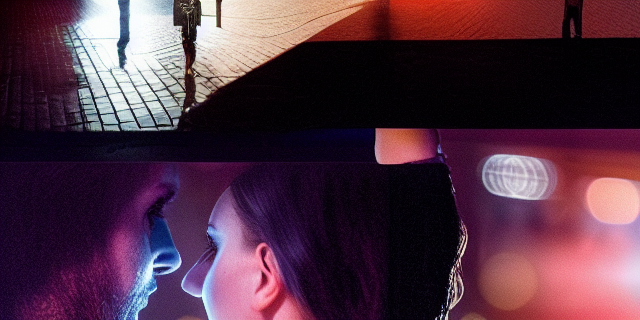

Rendering animation frame 1123 of 4380


Global seed set to 1125


long shot zoomed out,two people wrapped in each other's arms, dimly lit, high contrast, dark light, cinematic, atmospheric, ultra detailed, sharp, 8 k, trending on artstation, cgsociety, hdr, movie still frame, dynamic lighting, intricate detail, summer vibrancy, cinematic, centered, sharp focus, Unreal Engine 5!!! 1125
Angle: 0.0 Zoom: 1.04
Tx: 0.52 Ty: 0.66 Tz: 1.03
Rx: -0.03 Ry: -0.23 Rz: 0.0


 71%|███████   | 12/17 [00:01<00:00,  7.51it/s]

In [ ]:
# dispatch to appropriate renderer
if anim_args.animation_mode == '2D' or anim_args.animation_mode == '3D':
    render_animation(args, anim_args, animation_prompts, root)
elif anim_args.animation_mode == 'Video Input':
    render_input_video(args, anim_args, animation_prompts, root)
elif anim_args.animation_mode == 'Interpolation':
    render_interpolation(args, anim_args, animation_prompts, root)
else:
    render_image_batch(args, prompts, root)

In [ ]:
type(args)

In [ ]:
type(anim_args)

In [ ]:
# args.timestring = '20230412041010'#time.strftime('%Y%m%d%H%M%S')
# args.outdir = f'./resources/outputs/2023-04/StableFun/{artist}/{song_name}/{version}'
skip_video_for_run_all = False #@param {type: 'boolean'}
#@markdown **Manual Settings**
use_manual_settings = False #@param {type:"boolean"}
image_path = f"./resources/outputs/2023-04/StableFun/{artist}/{song_name}/{version}/{args.timestring}_%05d.png" #@param {type:"string"}
mp4_path = f"./resources/outputs/2023-04/StableFun/{artist}/{song_name}/{version}/video.mp4" #@param {type:"string"}
render_steps = False  #@param {type: 'boolean'}
path_name_modifier = "x0_pred" #@param ["x0_pred","x"]
make_gif = False
bitdepth_extension = "exr" if args.bit_depth_output == 32 else "png"

if skip_video_for_run_all == True:
    print('Skipping video creation, uncheck skip_video_for_run_all if you want to run it')
else:
    import os
    import subprocess
    from base64 import b64encode

    print(f"{image_path} -> {mp4_path}")

    if use_manual_settings:
        max_frames = "3650" #@param {type:"string"}
    else:
        if render_steps: # render steps from a single image
            fname = f"{path_name_modifier}_%05d.png"
            all_step_dirs = [os.path.join(args.outdir, d) for d in os.listdir(args.outdir) if os.path.isdir(os.path.join(args.outdir,d))]
            newest_dir = max(all_step_dirs, key=os.path.getmtime)
            image_path = os.path.join(newest_dir, fname)
            print(f"Reading images from {image_path}")
            mp4_path = os.path.join(newest_dir, f"{args.timestring}_{path_name_modifier}.mp4")
            max_frames = str(args.steps)
        else: # render images for a video
            image_path = os.path.join(args.outdir, f"{args.timestring}_%05d.{bitdepth_extension}")
            mp4_path = os.path.join(args.outdir, f"{args.timestring}.mp4")
            max_frames = str(anim_args.max_frames)

    # make video
    cmd = [
        'ffmpeg',
        '-y',
        '-vcodec', bitdepth_extension,
        '-r', str(fps),
        '-start_number', str(0),
        '-i', image_path,
        '-i', 'audio.wav',
        '-frames:v', max_frames,
        '-c:v', 'libx264',
        '-vf',
        f'fps={fps}',
        '-pix_fmt', 'yuv420p',
        '-crf', '17',
        '-preset', 'veryfast',
        '-pattern_type', 'sequence',
        mp4_path
    ]
    process = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    stdout, stderr = process.communicate()
    if process.returncode != 0:
        print(stderr)
        raise RuntimeError(stderr)

    mp4 = open(mp4_path,'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    # display.display(display.HTML(f'<video controls loop><source src="{data_url}" type="video/mp4"></video>') )
    
    if make_gif:
        gif_path = os.path.splitext(mp4_path)[0]+'.gif'
        cmd_gif = [
             'ffmpeg',
             '-y',
             '-i', mp4_path,
             '-r', str(fps),
             gif_path
         ]
        process_gif = subprocess.Popen(cmd_gif, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
print("Done!!")

end = time.time()
print(f"Total time taken: {end - start}s")

In [ ]:
# display.display(display.HTML(f'<video controls loop><source src="{data_url}" type="video/mp4"></video>') )